# Quantum Simulation-Based Optimization (QuSO) of a Cooling System

This notebook shows how to implement the QuSO algorithm for the cooling system problem presented in the paper: [Quantum Simulation-Based Optimization of a Cooling System](https://arxiv.org/abs/2504.15460).

In [1]:
import numpy as np
from classiq import *
import pyqsp
from pyqsp.angle_sequence import QuantumSignalProcessingPhases
from classiq.qmod.symbolic import log, logical_and
from sympy import sin, symbols, solve, simplify
from classiq.execution import *
from functools import reduce
from operator import mul
from scipy.optimize import curve_fit
import itertools

# Matrix Block Encoding
As discussed in the paper, we simulate the cooling system 

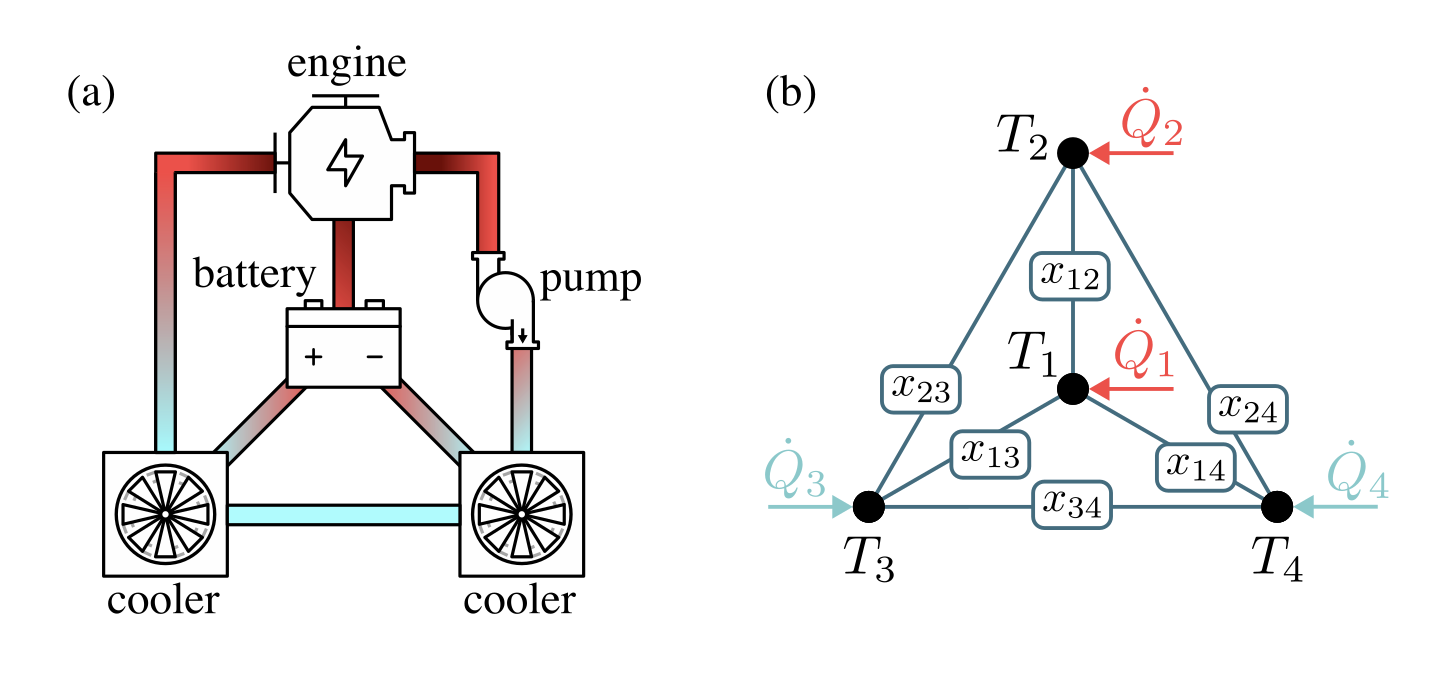

by solving the linear system of equations
$$
A(x)\tilde{T}=B,
$$
where $A(x)$ is the system matrix depending on the binary values $x_{ij}$, $\tilde{T}$ is the temperature vector, and $B$ is the vector containing the external heat or cooling sources.
In order to solve the system above, we need to block encode matrix $A(x)$, which will be shown in the following:

In [2]:
# define system parameters
# Environmental Parameters
T_env = 293       # Ambient temperature (K)
R_env = 0.001      # Convection resistance to ambient (K/W)

# Heat Flows (in Watts)
# Positive values indicate heat generation; negative values indicate cooling.
Q_1 = 2000    
Q_2 = 4000    
Q_3 = -200    
Q_4 = -2000   

# Inter-node Thermal Resistances (in K/W)
# These values lump together conduction and convection effects.
R_12 = 0.005
R_13 = 0.006
R_14 = 0.006
R_23 = 0.007
R_24 = 0.007
R_34 = 0.008

R_dict = {
    (0, 1): R_12,
    (0, 2): R_13,
    (0, 3): R_14,
    (1, 2): R_23,
    (1, 3): R_24,
    (2, 3): R_34
}

connections = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

conductance_coeffs = [1/R_12, 1/R_13, 1/R_14, 1/R_23, 1/R_24, 1/R_34, 1/(2*R_env), 0]
C_l = np.sum(conductance_coeffs)**(-1/2)
conductance_coeffs_amps = np.sqrt(conductance_coeffs)*C_l

B = np.array([Q_1, Q_2, Q_3, Q_4])
C_B = np.sum([el**2 for el in B])**(-1/2)
B_amps = C_B*B

In [3]:
# Classical construction of A(x)
def build_A(x):
    cons = []
    for i, x_ij in enumerate(x):
        if x_ij == 1:
            cons.append(connections[i])
    A = np.zeros((4, 4))
    for i in range(4):
        for j in range(4):
            if i == j:
                A[i, j] = 1/R_env + np.sum([1/R_dict[con] if i in con else 0 for con in cons])
            elif i < j:
                if (i, j) in cons:
                    A[i, j] = -1/R_dict[(i, j)]
            elif i > j:
                if (j, i) in cons:
                    A[i, j] = -1/R_dict[(j, i)]
    return A

For exampe, if we consider the case where all connections are switched on, we want to encode this matrix:

In [4]:
classical_matrix = build_A([1, 1, 1, 1, 1, 1])
print(classical_matrix)

[[1533.33333333 -200.         -166.66666667 -166.66666667]
 [-200.         1485.71428571 -142.85714286 -142.85714286]
 [-166.66666667 -142.85714286 1434.52380952 -125.        ]
 [-166.66666667 -142.85714286 -125.         1434.52380952]]


Let's do that using our block encoding:

In [5]:
@qfunc
def block_encode_2x2(aux: QNum, data: QArray[QBit]):
    """
    Returns the 2x2 block encoding: 1-X.
    """
    within_apply(
        lambda: H(aux),
        lambda: control(aux == 1, lambda: (X(data), U(0, 0, 0, np.pi, data))),
    )

@qfunc
def block_encode_2X2_first_qubit(flag: QBit, aux: QBit, data: QArray[QBit]):
    """
    Returns the 2x2 block encoding in the upper left block of a larger matrix padded with zeros.
    """
    lsb = QBit("lsb")
    msb = QNum("msb", data.len - 1, False, 0)

    bind(data, [lsb, msb])
    flag ^= msb > 0

    block_encode_2x2(aux, lsb)
    bind([lsb, msb], data)

@qfunc
def block_encode_2X2_arbitrary(
    i: CInt, j: CInt, flag: QBit, aux: QBit, data: QArray[QBit]
):
    """
    Returns the 2x2 block encoding at arbitrary positions i and j of a larger matrix padded with zeros.
    """
    within_apply(
        lambda: permute_block(i, j, data),
        lambda: block_encode_2X2_first_qubit(flag, aux, data),
    )


@qfunc
def permute_block(i: CInt, j: CInt, data: QArray[QBit]):
    """
    Returns the permutation operation of i->0 and j->1 in the qubit register data.
    """
    def get_bit(number, index):
        return (number >> index) & 1

    # move the i state to the 0 state
    repeat(
        data.len,
        lambda k: if_(
            get_bit(i, k) == 1, lambda: X(data[k]), lambda: IDENTITY(data[k])
        ),
    )

    #  # get the 1st index for which j^i is not 0
    j_updated = j ^ i
    highest_nonzero_bit = log(j_updated & ((~j_updated) + 1), 2)

    # # filp all 1 bits in updated j conditioned on the 1st bit
    repeat(
        data.len,
        lambda k: if_(
            logical_and(k != highest_nonzero_bit, get_bit(j_updated, k)),
            lambda: CX(data[highest_nonzero_bit], data[k]),
            lambda: IDENTITY(data),
        ),
    )

    # swap the qbit and the 0 qbit
    if_(highest_nonzero_bit != 0, lambda: SWAP(data[0], data[highest_nonzero_bit]), lambda: IDENTITY(data))

@qfunc
def combine_blocks(
    pair_list: CArray[CArray[CInt]],
    lcu_aux: QNum,
    flag: QBit,
    aux: QBit,
    data: QArray[QBit],
):
    """
    Returns the block encoding of several 2x2 matrices placed in a larger matrix padded with zeros.
    """
    within_apply(
        lambda: hadamard_transform(lcu_aux),
        lambda: repeat(
            pair_list.len,
            lambda index: control(
                lcu_aux == index,
                lambda: block_encode_2X2_arbitrary(
                    pair_list[index][0], pair_list[index][1], flag, aux, data
                ),
            ),
        ),
    )

@qfunc
def combine_blocks_coeffs(
    pair_list: CArray[CArray[CInt]],
    amplitudes: CArray[CReal],
    lcu_aux: QNum,
    flag: QBit,
    aux: QBit,
    data: QArray[QBit],
):
    """
    Returns the block encoding of several 2x2 matrices placed in a larger matrix padded with zeros with particular coefficients .
    """
    within_apply(
        lambda: inplace_prepare_amplitudes(amplitudes, 0, lcu_aux),
        lambda: repeat(
            pair_list.len,
            lambda index: control(
                lcu_aux == index,
                lambda: block_encode_2X2_arbitrary(
                    pair_list[index][0], pair_list[index][1], flag, aux, data
                ),
            ),
        ),
    )

@qfunc
def conditional_single_block(
    i: CInt, j: CInt, condition_var: QNum, flag: QBit, aux: QBit, data: QArray[QBit]
):
    """
    Returns the 2x2 block encoding at arbitrary positions i and j of a larger matrix padded with zeros 
    conditioned on condition_var.
    """
    control(
        ctrl = condition_var == 1,
        stmt_block = lambda: block_encode_2X2_arbitrary(i, j, flag, aux, data),
        else_block = lambda: X(flag) # else set flag to get 0 matrix in case condition_var == 0
    )


@qfunc
def conditional_combine_blocks(
    pair_list: CArray[CArray[CInt]],
    u: QArray[QBit],
    lcu_aux: QNum,
    flag: QBit,
    aux: QBit,
    data: QArray[QBit],
):
    """
    Returns the list of operations for the LCU block encoding of several 2x2 matrices placed in a larger matrix padded with zeros conditioned on qubits in u.
    """
    within_apply(
        lambda: hadamard_transform(lcu_aux),
        lambda: repeat(
            pair_list.len,
            lambda index: control(
                lcu_aux == index,
                lambda: conditional_single_block(
                    pair_list[index][0], pair_list[index][1], u[index], flag, aux, data
                ),
            ),
        ),
    )


@qfunc
def conditional_combine_blocks_coeffs(
    pair_list: CArray[CArray[CInt]],
    amplitudes: CArray[CReal],
    u: QArray[QBit],
    lcu_aux: QNum,
    flag: QBit,
    aux: QBit,
    data: QArray[QBit],
):
    """
    Returns the list of operations for the LCU block encoding of several 2x2 matrices placed in a larger matrix padded with zeros conditioned on qubits in u and with specific coefficients.
    """
    within_apply(
        lambda: inplace_prepare_amplitudes(amplitudes, 0, lcu_aux),
        lambda: repeat(
            pair_list.len,
            lambda index: control(
                lcu_aux == index,
                lambda: conditional_single_block(
                    pair_list[index][0], pair_list[index][1], u[index], flag, aux, data
                ),
            ),
        ),
    )

In [6]:
# Helper functions for matrix visualization
@qfunc
def prepare_ref(
    num_qubits: CInt, data: Output[QNum], data_ref: Output[QNum]
):
    """
    create a refernce variable such that it will 'tag' the input states, and it
    will be possible to measure the block encoded matrix
    """
    allocate(num_qubits, data)
    hadamard_transform(data)
    # 'duplicate' data to the refernce, such that variables are entangled
    data_ref |= data

def get_qprog(main, optimization_level = 0):
    execution_preferences = ExecutionPreferences(
        num_shots=None,
        backend_preferences=ClassiqBackendPreferences(
            backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
        ),
    )
    synthesis_preferences = Preferences(
        transpilation_option = "none", 
        timeout_seconds = 14400,
        optimization_level=optimization_level
    )

    qmod = create_model(
        entry_point = main, 
        execution_preferences=execution_preferences, 
        preferences=synthesis_preferences
    )
    qprog = synthesize(qmod)
    return qprog

def standardize_matrix(mat, threshold=1e-10):
    # normalize by a global phase of the first index
    mat = mat / np.exp(1j * np.angle(mat[0, 0]))

    # as we use the reference trick, normalize back to get the matrix coefficients
    mat *= np.sqrt(mat.shape[0])

    # truncate small values
    real_part = np.real(mat)
    imag_part = np.imag(mat)

    real_part[np.abs(real_part) < threshold] = 0
    imag_part[np.abs(imag_part) < threshold] = 0

    # Reconstruct the complex array with filtered real and imaginary parts
    return real_part + 1j * imag_part

def block_encoding_from_results(res, excluded_var_names=[]):
    """
    assuming `data_ref` is tagging the entries, and `data`is the result
    of the block encoding operation.
    all other variables are expected to be 0 in the block

    excluded_var_names - names of quantum variables that are not part of the "block" variables,
                         see the example with 'u' in the conditional block encoding
    """
    encoded_matrix_size = 2 ** len(res[0].value.output_qubits_map["data"])
    A = np.zeros((encoded_matrix_size, encoded_matrix_size), dtype=complex)
    for s in res[0].value.parsed_state_vector:
        
        block = True
        for var_name, var_val in s.state.items():
            if var_name == "data":
                row = var_val
                continue
            if var_name == "data_ref":
                col = var_val
                continue
            if var_val != 0 and var_name not in excluded_var_names:  # not in the block
                block = False
                break
        if block:
            A[int(col), int(row)] += s.amplitude
    return standardize_matrix(A)

@qfunc
def main(
    lcu_aux: Output[QNum], 
    flag: Output[QBit], 
    aux: Output[QBit], 
    data: Output[QNum],
    data_ref: Output[QNum]):

    allocate(3, lcu_aux)
    allocate(1, flag)
    allocate(1, aux)

    prepare_ref(2, data, data_ref)
    combine_blocks_coeffs(pair_list = connections, amplitudes = conductance_coeffs_amps, lcu_aux = lcu_aux, flag = flag, aux = aux, data = data)

In [7]:
qprog_block_encoding = get_qprog(main)
show(qprog_block_encoding)

Quantum program link: https://platform.classiq.io/circuit/2wOcPj26ir8EmjumIP1Df44OME4?login=True&version=0.76.0


In [8]:
res_block_encoding = execute(qprog_block_encoding).result()
A = block_encoding_from_results(res_block_encoding)
block_encoded_matrix = A*2/(C_l**2)
print(block_encoded_matrix)

[[1533.33333333+0.j -200.        +0.j -166.66666667+0.j -166.66666667+0.j]
 [-200.        +0.j 1485.71428571+0.j -142.85714286+0.j -142.85714286+0.j]
 [-166.66666667+0.j -142.85714286+0.j 1434.52380952+0.j -125.        +0.j]
 [-166.66666667+0.j -142.85714286+0.j -125.        +0.j 1434.52380952+0.j]]


In [9]:
assert np.allclose(np.real(block_encoded_matrix), np.real(classical_matrix), atol=1e-2)

We have successfully block-encoded the matrix from above!

# QSVT for Matrix Inversion and Solving our Linear System
Next, we use our block encoding to solve our linear system (cf. above).

In [10]:
# compute phase angles for the 1/x polynomial
def getOneOverXPhases(epsilon=0.05, kappa=5):
    pcoefs, C_p = pyqsp.poly.PolyOneOverX().generate(kappa, return_coef=True, ensure_bounded=True, return_scale=True, epsilon=epsilon)
    phi_pyqsp = QuantumSignalProcessingPhases(pcoefs, signal_operator="Wx")
    C_p = C_p[0]

    # change the R(x) to W(x), as the phases are in the W(x) conventions
    phases = np.array(phi_pyqsp)
    phases[1:-1] = phases[1:-1] - np.pi / 2
    phases[0] = phases[0] - np.pi / 4
    phases[-1] = phases[-1] + (2 * (len(phases) - 1) - 1) * np.pi / 4
    phases = -2 * phases

    return phases, C_p

phases, C_p = getOneOverXPhases(epsilon=0.1, kappa=3)

b=30, j0=14
[PolyOneOverX] minimum [-3.53259398] is at [-0.20533021]: normalizing
[PolyOneOverX] bounding to 0.9


In [11]:
# Implementation of the QSVT-based Linear System Solver
lcu_aux_size = int(np.log2(len(conductance_coeffs_amps)))
data_size = int(np.log2(len(B_amps)))

class Block(QStruct):
    lcu_aux: QNum[lcu_aux_size, False, 0]
    flag: QBit
    aux: QBit 
    
class BlockEncodedState(QStruct):
    block: Block
    data: QArray[QBit, data_size] 

class QsvtState(QStruct):
    qsvt_aux: QBit 
    qsvt_real_aux: QBit
    state: BlockEncodedState

@qfunc
def identify_block(state: BlockEncodedState, block_zero_qbit: QBit):
    block_qubits = QNum(size = state.block.size, is_signed=False, fraction_digits=0)
    data = QArray(length=state.data.size)

    bind(state, [block_qubits, data])
    block_zero_qbit ^= block_qubits == 0
    bind([block_qubits, data], state)

@qfunc(synthesize_separately=True)
def qsvt_solve_system(
    b_amps: CArray[CReal],
    block_encoding: QCallable[QArray[QBit]],
    phases: CArray[CReal],
    qsvt_state: QsvtState,
) -> None:
    """
    QSVT implementation to solve a linear system Ax=b.
    """

    # Prepare b as a quantum state in amplitude encoding.
    inplace_prepare_amplitudes(b_amps, 0, qsvt_state.state.data)

    hadamard_transform(qsvt_state.qsvt_real_aux)
    control(
        ctrl = qsvt_state.qsvt_real_aux==0,
        stmt_block=lambda: qsvt_inversion(
            phase_seq=phases,
            block_encoding_cnot=lambda qvar, block_zero_qbit: identify_block(qvar, block_zero_qbit),
            u=lambda qvar: block_encoding(qvar),
            qvar=qsvt_state.state,
            aux=qsvt_state.qsvt_aux,
        ),
        else_block=lambda: invert(
            lambda: qsvt_inversion(
                phase_seq=phases,
                block_encoding_cnot=lambda qvar, block_zero_qbit: identify_block(qvar, block_zero_qbit),
                u=lambda qvar: block_encoding(qvar),
                qvar=qsvt_state.state,
                aux=qsvt_state.qsvt_aux,
            )
        )
    )
    hadamard_transform(qsvt_state.qsvt_real_aux)

In [12]:
# Demonstration of the QSVT-based Linear System Solver
@qfunc
def block_encoding_demo(
    pair_list: CArray[CArray[CInt]],
    amplitudes: CArray[CReal],
    state: BlockEncodedState
):
    lcu_aux = state.block.lcu_aux
    flag = state.block.flag
    aux = state.block.aux
    data = state.data

    combine_blocks_coeffs(pair_list = pair_list, amplitudes = amplitudes, lcu_aux = lcu_aux, flag = flag, aux = aux, data = data)


@qfunc
def conditional_block_encoding(
    pair_list: CArray[CArray[CInt]],
    amplitudes: CArray[CReal],
    u: QArray[QBit],
    state: BlockEncodedState
):
    lcu_aux = state.block.lcu_aux
    flag = state.block.flag
    aux = state.block.aux
    data = state.data

    conditional_combine_blocks_coeffs(pair_list = pair_list, amplitudes = amplitudes, u = u, lcu_aux = lcu_aux, flag = flag, aux = aux, data = data)

@qfunc
def main(
    qsvt_state: Output[QsvtState]
): 
    allocate(qsvt_state)

    qsvt_solve_system(
        b_amps = B_amps,
        block_encoding = lambda q_var: block_encoding_demo(pair_list = connections, amplitudes = conductance_coeffs_amps, state = q_var),
        phases = phases,
        qsvt_state = qsvt_state
    )

#### Synthesize circuit

In [13]:
matrix_inverse_qprog=get_qprog(main, optimization_level=2)
show(matrix_inverse_qprog)

Quantum program link: https://platform.classiq.io/circuit/2wOdQ98RJpWzfHUL6xqy19aAkAH?login=True&version=0.76.0


#### Execute circuit

In [14]:
matrix_inverse_res = execute(matrix_inverse_qprog).result()

# extract the result
T_tilde = np.zeros(4, dtype=complex)
for i in range(len(matrix_inverse_res[0].value.parsed_state_vector)):
    q_dict = matrix_inverse_res[0].value.parsed_state_vector[i]['qsvt_state']
    temp = 0
    temp += q_dict['qsvt_aux']
    temp += q_dict['state']['block']['lcu_aux']
    temp += q_dict['state']['block']['flag']
    temp += q_dict['state']['block']['aux']
    if temp == 0 and abs(matrix_inverse_res[0].value.parsed_state_vector[i].amplitude) > 1e-5:
        T_tilde[int(str(q_dict['state']['data'][1])+str(q_dict['state']['data'][0]), 2)] = abs(matrix_inverse_res[0].value.parsed_state_vector[i].amplitude)

In [15]:
qsvt_solution = np.abs(T_tilde*C_l**2/(2*C_p*C_B))
classical_solution = np.abs(np.linalg.solve(build_A([1, 1, 1, 1, 1, 1]), B))

print("QSVT solution:", qsvt_solution)
print("Classical solution:", classical_solution)

QSVT solution: [1.58401335 2.8248717  0.2310307  0.9229191 ]
Classical solution: [1.60481928 2.84578313 0.25179803 0.90240044]


As the QSVT result agrees with the classical solution of our linear system up to an acceptable error, we have successfully solved the linear system using QSVT.

# QuSO Algorithm
Only a few operations are missing to build the QuSO algorithm. In the following, we will implement the Quantum Amplitude Estimation (QAE) and Quantum Phase Application (QPA) routine to embed all operations in a QuSO circuit.

In [16]:
def polynomial_coefficients_from_function(func, num_bits):
    MIN_COEFF = 10e-7

    def prod(iterable):
        return reduce(mul, iterable, 1)

    lookup_table = {tuple(map(int, format(x, f'0{num_bits}b'))): func(x) for x in
                    range(2 ** num_bits)}

    x_symbols = symbols(f'x0:{num_bits}')
    a_symbols = symbols(f'a0:{2 ** num_bits}')

    # Construct the polynomial expression
    polynomial_expr = sum(a_symbols[i] * prod(
        (x_symbols[j]) ** int(bit) for j, bit in enumerate(f'{i:0{num_bits}b}')) for i
                          in range(2 ** num_bits))

    # Setup equations based on the lookup table
    equations = [polynomial_expr.subs(dict(zip(x_symbols, k))) - v for k, v in
                 lookup_table.items()]

    # Solve for coefficients
    solved_coeffs = solve(equations, a_symbols)

    # Clean small coefficients
    solved_coeffs = {var: float(coeff) if abs(coeff) > MIN_COEFF else 0 for var, coeff in solved_coeffs.items()}

    # Substitute the solved coefficients back into the polynomial expression
    polynomial_with_coeffs = polynomial_expr.subs(solved_coeffs)
    print("Polynomial Expression:", polynomial_with_coeffs)

    # Create substitution dictionary for 1 - x_i/2
    substitution_dict = {x: (1 - x) / 2 for x in x_symbols}

    # Apply the substitution to the polynomial expression
    polynomial_with_substitution = polynomial_with_coeffs.subs(substitution_dict)

    # Simplify the polynomial expression after substitution
    simplified_polynomial = simplify(polynomial_with_substitution)

    # Extract coefficients after substitution
    substituted_coefficients_dict = {}
    for i in range(2 ** num_bits):
        binary_tuple = tuple(int(bit) for bit in format(i, f'0{num_bits}b'))
        term = prod(x_symbols[j] ** int(bit) for j, bit in enumerate(binary_tuple))
        coefficient = simplified_polynomial.as_coefficients_dict().get(term, 0)
        substituted_coefficients_dict[binary_tuple] = float(coefficient) if abs(coefficient) > MIN_COEFF else 0

    # Handle the constant term
    constant_term = simplified_polynomial.as_coefficients_dict().get(1, 0)
    if abs(constant_term) > MIN_COEFF:
        substituted_coefficients_dict[(0,) * num_bits] = float(constant_term)

    return substituted_coefficients_dict, simplified_polynomial



def polynomial_to_expression(coefficients_dict: dict, qae_phase_reg: QArray[QBit]):
    # Create the polynomial expression
    polynomial_expr = 0.0
    for var_list, coeff in coefficients_dict.items():
        term = coeff
        for x, p in zip(qae_phase_reg, var_list):
            if p:  # skip the multiply when p == 0
                term *= x
        polynomial_expr += term
    return polynomial_expr

def get_func_polynomial_expression(func, c, precision, qae_phase_reg):
    # Compute the coefficients and polynomial
    coefficients_dict, polynomial = polynomial_coefficients_from_function(func, precision)

    # can be done exact with polynomial of the same order of the function
    return c*polynomial_to_expression(coefficients_dict, qae_phase_reg)

We take 5 QPE phase qubits `qpe_phase_size`.

In [17]:
# define a simple QAOA model

qpe_phase_size = 5
num_layers = 1
qaoa_reg_size = 6

func = lambda x: sin(np.pi * x / (2 ** qpe_phase_size))


class ProblemRegs(QStruct):
    qaoa_vars: QArray[qaoa_reg_size]
    phase_estimate: QNum[qpe_phase_size, UNSIGNED, qpe_phase_size]



@qfunc(synthesize_separately=True)
def my_qsvt_solve_system(u: QArray, qsvt_state: QArray):

    qsvt_solve_system(
        b_amps = B_amps,
        block_encoding = lambda q_var: conditional_block_encoding(
            pair_list = connections,
            amplitudes = conductance_coeffs_amps,
            u = u,
            state = q_var
        ),
        phases = phases,
        qsvt_state = qsvt_state
    )


# QPA implementation
@qfunc
def phase_application(
    qae_phase: QArray,
    gamma: CReal
    ):
    phase(
        expr=get_func_polynomial_expression(func, 1, qpe_phase_size, qae_phase),
        theta = gamma
    )

@qfunc(synthesize_separately=True)
def qaoa_system_cost(
        qaoa_vars: QArray,
        phase_reg: QNum,
        qsvt_state: QsvtState,
        gamma: CReal,
) -> None:

    within_apply(
        within=lambda: amplitude_estimation(
            oracle=lambda x: reflect_about_zero(x),
            space_transform=lambda y: my_qsvt_solve_system(qaoa_vars, y),
            phase=phase_reg,
            packed_vars=qsvt_state
        ),
        apply=lambda: phase_application(
            qae_phase=phase_reg,
            gamma=gamma
        )
    )


@qfunc(synthesize_separately=True)
def qaoa_estimate_cost(
        qaoa_vars: QArray,
        phase_reg: QNum,
        qsvt_state: QsvtState,
) -> None:
    amplitude_estimation(
        oracle=lambda x: reflect_about_zero(x),
        space_transform=lambda y: my_qsvt_solve_system(qaoa_vars, y),
        phase=phase_reg,
        packed_vars=qsvt_state
    )

@qfunc
def qaoa_mixer(reg: QArray, beta: CReal) -> None:
        repeat(
            count=reg.len,
            iteration=lambda index: RX(theta = beta, target = reg[index]),
        )



@qfunc
def main(
        params: CArray[CReal, num_layers * 2],
        regs: Output[ProblemRegs]
) -> None:
    # Allocate QAOA register
    allocate(regs.size, regs)
    hadamard_transform(regs.qaoa_vars)

    # Allocate QSVT registers
    qsvt_state = QsvtState("qsvt_state")
    allocate(qsvt_state.size, qsvt_state)

    # QAOA Layers
    repeat(
        num_layers,
        lambda i: (
            qaoa_system_cost(
                qaoa_vars=regs.qaoa_vars,
                phase_reg=regs.phase_estimate,
                qsvt_state=qsvt_state,
                gamma=params[i],
            ),
            qaoa_mixer(regs.qaoa_vars, beta=params[num_layers + i])
        )
    )

    # Estimate cost
    qaoa_estimate_cost(
        qaoa_vars=regs.qaoa_vars,
        phase_reg=regs.phase_estimate,
        qsvt_state=qsvt_state,
    )

#### The circuit becomes very big. Thus, we do not synthesize the circuit in this demo-notebook because it takes a lot of time.

In [18]:
# The line below would synthesize the circuit but we avoid that.
# QuSo_qprog = get_qprog(main)
# show(QuSo_qprog)

As explained in the paper, we can still simulate how QuSO would perform by preparing the state after QAE instead of running QAE.

In this example, we synthesize the circuit with one layer of QAOA and 1 phase qubit `n_phase_qubits` to shoten the synthesis time. You can increase `n_phase_qubits` to 5 and get better results.

In [19]:
# load precomputed cost values
costs = np.load("data/costs.npy")

num_connections = 6

n_phase_qubits = 1
num_layers = 1

# classical probability function after Quantum Phase Estimation
def qpe_probability_function(y, theta, M):
    y = np.array(y, dtype=np.float64)
    numerator = 1 - np.cos(2 * np.pi * (y - theta * M))
    denominator = 1 - np.cos((2 * np.pi / M) * (y - theta * M))
    # When denominator is close to zero, use the limiting value (which gives a ratio of M^2).
    ratio = np.where(np.abs(denominator) < 1e-8, M**2, numerator / denominator)
    P = ratio / (M**2)
    return P

# classical probability function after QAE
def qae_probability_function(y, theta, M):
    term1 = qpe_probability_function(y, theta, M)
    term2 = qpe_probability_function(y, -theta, M)
    return 0.5 * (term1 + term2)

# Function to estimate theta using QAE using curve fitting 
# Further details: https://arxiv.org/abs/2409.15752v1
def estimate_theta_qae(probabilities):
    probabilities = np.array(probabilities, dtype=np.float64)
    M = len(probabilities)  # Number of states (M = 2^n).
    y_vals = np.arange(M)
    
    max_index = np.argmax(probabilities)
    initial_guess = (max_index / M)
    
    # Define narrow bounds around the initial guess.
    lower_bound = max(0, initial_guess - 0.5 / M)
    upper_bound = min(1, initial_guess + 0.5 / M)
    bounds = ([lower_bound], [upper_bound])
    
    # Define the model function with theta as the only free parameter.
    def model(y, theta):
        return qae_probability_function(y, theta, M)
    
    # Attempt two fits (starting at the lower and upper bounds) to help avoid local minima.
    try:
        popt1, pcov1 = curve_fit(model, y_vals, probabilities, p0=[lower_bound], bounds=bounds)
    except Exception as e:
        popt1, pcov1 = (np.array([np.nan]), np.array([[np.inf]]))
        
    try:
        popt2, pcov2 = curve_fit(model, y_vals, probabilities, p0=[upper_bound], bounds=bounds)
    except Exception as e:
        popt2, pcov2 = (np.array([np.nan]), np.array([[np.inf]]))
    
    var1 = pcov1[0, 0] if np.isfinite(pcov1[0, 0]) else np.inf
    var2 = pcov2[0, 0] if np.isfinite(pcov2[0, 0]) else np.inf
    
    if var1 < var2:
        theta_est = popt1[0]
    else:
        theta_est = popt2[0]
    
    return theta_est

# classical function to compute the amplitudes of the QAE for some amplitude a and n_phase phase qubits
def qae_full_amplitudes(a, n_phase):
    M = 2 ** n_phase
    theta = np.arcsin(a) / np.pi  
    theta_prime = np.arcsin(a)  

    c_plus  = (np.sin(theta_prime) - 1j*np.cos(theta_prime)) / np.sqrt(2)
    c_minus = (np.sin(theta_prime) + 1j*np.cos(theta_prime)) / np.sqrt(2)
    
    def A_QPE(y, phi):
        k = np.arange(M)
        return np.sum(np.exp(-2j * np.pi * k * (y/M - phi))) / M

    A_plus  = np.array([A_QPE(y,  theta) for y in range(M)])
    A_minus = np.array([A_QPE(y, -theta) for y in range(M)])
    
    amp_good = (c_plus * A_plus + c_minus * A_minus) / np.sqrt(2)
    amp_bad  = (1j * c_plus * A_plus - 1j * c_minus * A_minus) / np.sqrt(2)
    
    full_state = np.zeros(2 * M, dtype=np.complex128)
    for y in range(M):
        full_state[y * 2 + 0] = amp_bad[y]
        full_state[y * 2 + 1] = amp_good[y]
    
    return full_state

# computing QAE amplitudes for all configurations in configs
def compute_qae_amplitudes(configs, amplitudes, n_phase):
    qae_amplitudes = []
    for i, config in enumerate(configs):
        qae_amplitudes.append(qae_full_amplitudes(amplitudes[i], n_phase))

    return qae_amplitudes

# computing all configs
all_configs = [list(bits) for bits in itertools.product([0, 1], repeat=6)]

qae_amplitudes = compute_qae_amplitudes(all_configs, costs, n_phase_qubits)
qae_amplitudes_magnitudes = np.array([np.abs(amps) for amps in qae_amplitudes])
qae_amplitudes_phases = np.array([np.angle(amps) for amps in qae_amplitudes])

@qfunc
def mixer_layer(reg: QArray, beta: CReal) -> None:
    repeat(
        count=reg.len,
        iteration=lambda index: RX(theta = -2*beta, target = reg[index]),
    )

@qfunc
def phase_application(
    qae_phase: QArray,
    gamma: CReal
    ):
    phase(
        expr=get_func_polynomial_expression(func, 1.0, n_phase_qubits, qae_phase),
        theta = gamma
    )


@qfunc(generative=True)
def dummy_qae(magnitudes_list: CArray[CArray[CReal]], phases_list: CArray[CArray[CReal]], qae_phase: QArray, reg: QNum):
    dummy_data = QBit()
    full_qae = QArray()
    allocate(1, dummy_data)
    bind([qae_phase, dummy_data], full_qae)
    for index in range(len(all_configs)):
        control(reg == index, lambda: inplace_prepare_complex_amplitudes(magnitudes_list[index], phases_list[index], full_qae))
    bind(full_qae, [qae_phase, dummy_data])

@qfunc
def dummy_cost_layer(qae_phase: QArray, reg: QArray, gamma: CReal) -> None:
    within_apply(
        lambda: dummy_qae(qae_amplitudes_magnitudes, qae_amplitudes_phases, qae_phase, reg),
        lambda: phase_application(qae_phase, gamma)
    )

@qfunc
def qaoa_layer(qae_phase: QArray, reg: QArray, gamma: CReal, beta: CReal) -> None:
    dummy_cost_layer(qae_phase, reg, gamma)
    mixer_layer(reg, beta)

@qfunc(generative=True)
def qaoa_circuit(
    gammas: CArray[CReal],
    betas: CArray[CReal],
    reg: QArray
):
    qae_phase = QArray()
    allocate(n_phase_qubits, qae_phase)
    hadamard_transform(reg)
    for i in range(gammas.len):
        qaoa_layer(qae_phase, reg, gammas[i], betas[i])

#### Synthesizing the variational circuit

In [20]:
print(f"Dummy QuSO for {n_phase_qubits} phase qubits and a number of layers {num_layers}:")

@qfunc
def main(
    gammas: CArray[CReal, num_layers],
    betas: CArray[CReal, num_layers],
    reg: Output[QArray]
) -> None:
    allocate(num_connections, reg)
    qaoa_circuit(gammas, betas, reg)

dummy_qprog = get_qprog(main)
show(dummy_qprog)

Dummy QuSO for 1 phase qubits and a number of layers 1:
Polynomial Expression: 0.0980171403295606*x0
Quantum program link: https://platform.classiq.io/circuit/2wOdo3De9qjNnwMUsqWKtdjN7KS?login=True&version=0.76.0


By using more phase qubits and optimizing on the gamma and betas parameters, you can find the optimal solution with high probability.